In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from adaptive_latents import Pipeline, CenteringTransformer, proSVD, sjPCA, AnimationManager, KernelSmoother, SwitchingParallelTransformer, mmICA
import adaptive_latents.plotting_functions as pf
from adaptive_latents import datasets


In [2]:
d  = datasets.Zong22Dataset(2)

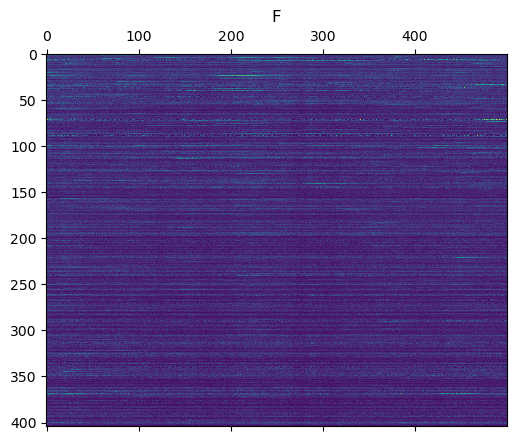

In [3]:
plt.matshow(d.F[:,:500])
plt.title("F");

In [4]:
planes = []
for i in range(1000):
    d.raw_images.seek(i)
    planes.append(np.array(d.raw_images))

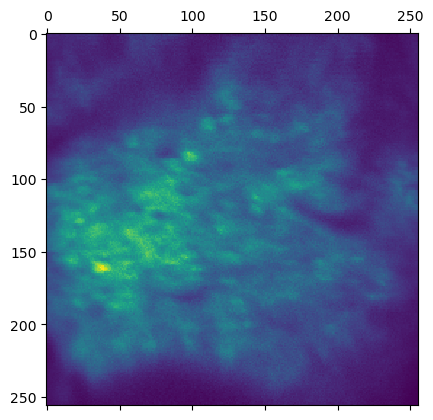

In [5]:
plt.matshow(np.mean(planes, axis=0))

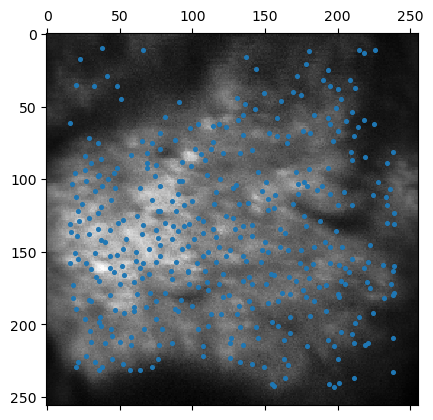

In [6]:

im = np.mean(planes, axis=0)
# im = np.zeros((ops['Ly'], ops['Lx']))

# for n in range(0,ncells):
#     ypix = stat[n]['ypix'][~stat[n]['overlap']]
#     xpix = stat[n]['xpix'][~stat[n]['overlap']]
#     im[ypix,xpix] = 0


plt.matshow(-im, cmap='Grays')
xs, ys = list(zip(*[cell['med'] for cell in d.stat]))

plt.scatter(ys,xs, s=7)
# plt.colorbar()


In [7]:
# p = Pipeline([
#     CenteringTransformer(),
#     KernelSmoother(.2*neural_Fs),
#     proSVD(k=6),
#     sjPCA()
# ])
# 
# last_draw_time = 300
# draw_dt = 1/20
# exit_time = 310
# 
# tq = tqdm(total=exit_time)
# 
# with AnimationManager(n_cols=2, figsize=(10,5)) as am:
#     output_l = []
#     for o, s in p.streaming_run_on([neural_data], return_output_stream=True):
#         tq.update(o.t - tq.n)
#         output_l.append(o)
#         
#         if o.t > last_draw_time + draw_dt:
#             ax: plt.Axes = am.axs[0,1]
#             old_lims = ax.axis()
#             ax.cla()
#             outputs = np.squeeze(output_l[50:])
#             ax.plot(outputs[-20:,0], outputs[-20:,1])
#             ax.scatter(outputs[-1,0], outputs[-1,1])
#             ax.scatter(outputs[:,0], outputs[:,1], s=5, alpha=.25, c='C0', edgecolors='none')
#             pf.use_bigger_lims(ax, old_lims=old_lims)
# 
#             ax: plt.Axes = am.axs[0,0]
#             ax.cla()
#             frame = np.argmin(np.abs(video_t - o.t))
#             points = ['nose', 'bodycenter', 'mouse']
#             ax.scatter([beh.loc[frame, point + "_x"] for point in points], [beh.loc[frame, point + "_y"] for point in points])
#             ax.imshow(video[frame])
#             ax.set_title(f"t={o.t:.1f}")
#             
#             
#             last_draw_time = o.t
#             am.grab_frame()
#         
#         if o.t > exit_time:
#             break


In [ ]:

for i in [0,1]:
    p_prosvd = Pipeline([
        CenteringTransformer(),
        KernelSmoother(.2*d.neural_Fs),
        proSVD(k=6),
    ])

    temp_p = Pipeline([
        p_prosvd,
        SwitchingParallelTransformer([jpca := sjPCA(), ica := mmICA()])
    ])

    if i == 1:
        temp_p.offline_run_on([d.neural_data])
        temp_p.freeze()
        p_prosvd.steps[1] = KernelSmoother(.2*d.neural_Fs)



    last_draw_time = 0
    draw_dt = 1/20
    exit_time = d.neural_data.t.max()

    tq = tqdm(total=exit_time)

    with AnimationManager(n_cols=2, n_rows=2, figsize=(10,10)) as am:
        pro_output = [[], []]
        jpca_output = [[], []]
        ica_output = [[], []]
        
        for o, s in Pipeline([]).streaming_run_on([d.neural_data], return_output_stream=True):
            tq.update(o.t - tq.n)
            
            o = p_prosvd.partial_fit_transform(o, s)
            o2 = jpca.partial_fit_transform(o)
            o3 = ica.partial_fit_transform(o)
            if not np.isnan(o2 + o3).any():
                pro_output[0].append(o[0,0])
                pro_output[1].append(o[0,1])
                
                jpca_output[0].append(o2[0,0])
                jpca_output[1].append(o2[0,1])


                ica_output[0].append(o3[0,0])
                ica_output[1].append(o3[0,1])

            if o.t > last_draw_time + draw_dt:
                ax: plt.Axes = am.axs[0,0]
                ax.cla()
                frame = np.argmin(np.abs(d.video_t - o.t))
                points = ['nose', 'bodycenter', 'mouse']
                ax.scatter([d.behavior_df.loc[frame, point + "_x"] for point in points], [d.behavior_df.loc[frame, point + "_y"] for point in points])
                ax.imshow(d.behavior_video[frame])
                ax.set_title(f"t={o.t:.1f}")

                for output, pos, name in [(pro_output, (0, 1), 'pro'), (jpca_output, (1, 0), 'jpca'), (ica_output, (1, 1), 'ica')]:
                    ax: plt.Axes = am.axs[pos]
                    old_lims = ax.axis()
                    ax.cla()
                    ax.plot(output[0][-20:], output[1][-20:])
                    ax.scatter(output[0][-1:],output[1][-1:])
                    ax.scatter(output[0], output[1], s=5, alpha=.25, c='C0', edgecolors='none')
                    pf.use_bigger_lims(ax, old_lims=old_lims)
                    ax.set_title(name)

                last_draw_time = o.t
                am.grab_frame()

            if o.t > exit_time:
                break


  0%|          | 0/579.9333333333333 [00:00<?, ?it/s]